# Generative Adversarial Networks (GANs)

In [1]:
# This part is necessary, otherwise when a matplotlib command is executed a 'kernel died' error is taken and execution stops.

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np

import torch

from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

%matplotlib inline

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    

## Load MNIST Data

In [4]:
batch_size = 128

#Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Image shape torch.Size([1, 28, 28])


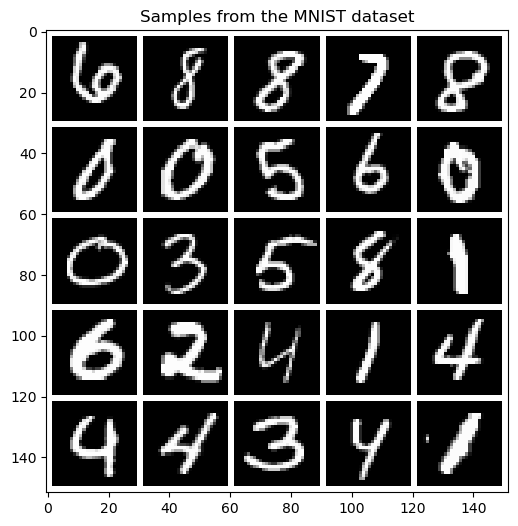

In [5]:
num_imgs_to_visualize = 25  # number of images we'll display
batch = next(iter(dataloader))  # take a single batch from the dataset
img_batch = batch[0]  # extract only images and ignore the labels (batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]  # extract only a subset of images

# Q2: What's the shape of my image?
# format is (B,C,H,W), B - number of images in batch, C - number of channels, H - height, W - width
print(f'Image shape {img_batch_subset.shape[1:]}')  # we ignore shape[0] - number of imgs in batch.

# Q3: How do my images look like?
# Creates a 5x5 grid of images, normalize will bring images from [-1, 1] range back into [0, 1] for display
# pad_value is 1. (white) because it's 0. (black) by default but since our background is also black,
# we wouldn't see the grid pattern so I set it to 1.
grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)  # from CHW -> HWC format that's what matplotlib expects! Get used to this.

plt.figure(figsize=(6, 6))
plt.title("Samples from the MNIST dataset")
plt.imshow(grid)
plt.show()


## Generator Network

In [3]:
def gen_block(dim_in, dim_out):
    block=nn.Sequential(nn.Linear(dim_in, dim_out),
                        nn.BatchNorm1d(dim_out),
                        nn.ReLU(inplace=True))
    
    return block

In [4]:
class GeneratorNetwork(nn.Module):

    def __init__(self, noise_dim=10, im_dim=784, hidden_dim=128):
        super(GeneratorNetwork, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            gen_block(noise_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim * 2),
            gen_block(hidden_dim * 2, hidden_dim * 4),
            gen_block(hidden_dim * 4, hidden_dim * 8),
            
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()

        )
    def forward(self, noise):
        
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        
        return self.gen

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        return self.disc

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

### DO NOT EDIT ###
#device = 'cuda'
device = 'cpu'

In [9]:
gen = GeneratorNetwork(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device=device)
    fake_image = gen(noise)
    pred_disc_fake = disc(fake_image.detach())
    loss_fake = criterion(pred_disc_fake, torch.zeros_like(pred_disc_fake))
    pred_disc_real = disc(real)
    loss_real = criterion(pred_disc_real, torch.ones_like(pred_disc_real))
    disc_loss = 1/2 * (loss_fake + loss_real)
    return disc_loss

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device=device)
    fake_image = gen(noise)
    pred_disc_fake = disc(fake_image)
    gen_loss = criterion(pred_disc_fake, torch.ones_like(pred_disc_fake))
    return gen_loss

In [12]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
    
    print('Epoch: ', epoch+1, '/',n_epochs)
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()


        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")


        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
                
        cur_step += 1
        

Epoch:  1 / 200


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  2 / 200


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  3 / 200


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 